<div style="background-color:royalblue">
<img src="https://d3njjcbhbojbot.cloudfront.net/web/bundles/userModal/images/coursera-logo.svg">
</div>    

# <b style="color:#3b5998">www-coursera-downloader </b>

- this release: 20160625
- added feature: 
  - quiz downloader
  - creation of m3u playlist
  - added  <b style="color:#3b5998">colorful</b> heading and images

(c) Jansen Simanullang, 2016-2018.

## <b style="color:#3b5998">A. Requirements</b>

### <b style="color:#3b5998">(1) Install Mozilla Geckodriver</b>
<img src="https://avatars2.githubusercontent.com/u/131524?s=200&v=4" width="75" height="75" alt="@mozilla" align="center"><br>
<li>Install [Mozilla Geckodriver](https://github.com/mozilla/geckodriver/releases/)
</li>

#### <b style="color:royalblue">Check Geckodriver version</b>

In [2]:
!echo Checking geckodriver version...
!geckodriver --version

Checking geckodriver version...
geckodriver 0.20.1

The source code of this program is available from
testing/geckodriver in https://hg.mozilla.org/mozilla-central.

This program is subject to the terms of the Mozilla Public License 2.0.
You can obtain a copy of the license at https://mozilla.org/MPL/2.0/.


### <b style="color:#3b5998">(2) Install Some Python Packages</b>
<img src="https://pypi.org/static/images/logo-small.6eef541e.svg">

In [3]:
!pip install -q bs4 jupyter_contrib_nbextensions pillow splinter
!jupyter nbextension enable python-markdown/main

Enabling notebook extension python-markdown/main...
      - Validating: OK


In [34]:
from splinter import Browser
import base64, getpass, json, os, re, requests, sys, time
from bs4 import BeautifulSoup
from mutagen.mp4 import MP4

## <b style="color:#3b5998">B. Definitions</b>

### <b style="color:royalblue">B. 1 Some constants</b>

In [5]:
# LOADING TIME
# WARNING: this will impact your user experience!
# adjust loading time according to your network speed!
# loading time in seconds

loading_time = 5

# HOMEPAGE
homepage='https://www.coursera.org'

# VIDEO RESOLUTION
# available resolution:
# 'hi', 'low' or 'med'
# choose according to your preference
resolution = {'low':'360','med':'540','hi':'720'}
chosen_res = 'hi'

# INITIAL DIRECTORY
initial_dirname = os.getcwd()

###  <b style="color:royalblue">B.2 Helper Functions</b>

<img src="https://www.3di.co.uk/wp-content/uploads/2016/06/Define.png" height="150" width="250">

In [6]:
def safe_text(str_text):
    erasable = [':','/']
    for e in erasable:   
        str_text = str_text.replace(e, ' ')  
    while '  ' in str_text:
        str_text = str_text.replace('  ',' ')
    return str_text

def create_download_dir(dirname):
    
    dirname = safe_text(dirname)
    
    try:
        os.mkdir(dirname)
    except:
        pass
    
    os.chdir(dirname)
    print(os.getcwd())

# SCREENSHOT
def screenshot():
    browser.driver.save_screenshot('screenshot.png')
    from PIL import Image
    return Image.open('screenshot.png')

# cjson helper functions

def encode_cjson(text):
    return base64.b64encode(bytes(str(text), "utf-8"))

def save_cjson(text):
    text = encode_cjson(text)
    with open('coursera.json','wb+') as f:
        f.write(bytes(str(text),"utf-8"))
    f.close()

def read_cjson():
    
    if os.path.isfile('coursera.json'):
        with open('coursera.json','rb') as f:
            a = f.read()
        f.close()
    else:
        print('credential file not found')
    return str(a).split("'")[1]

def decode_cjson(text):
    return str(base64.b64decode(text)).split("'")[1]

def get_cjson():

    text = read_cjson()
    
    uid = json.loads(decode_cjson(text))
    return uid

def remove_cjson():
    
    if os.path.isfile('coursera.json'):
        os.remove('coursera.json')

def get_credential():

    if os.path.isfile('coursera.json'):
        username = get_cjson()['user']
        password = get_cjson()['password']
    else:
        username = input('User Name:')
        password = getpass.getpass('Password:')
        text = '{"user":"'+username+'", "password":"'+password+'"}'
        save_cjson(text)
        
    return username, password

def remove_credential():
    remove_cjson()
    print('credential removed...')
    return

def reset_credential():
    remove_cjson()
    username, password = get_credential()
    return username, password

# vtt file conversion

def read_text_file(file_name):
    f = open(file_name, "r")
    print("vtt file being converted to srt: " + file_name + "\n")  
    return f.read()

def file_create(file_name, str_data):
    try:  
        f = open(file_name, "w")
        f.writelines(str(str_data))
        f.close()
    except IOError:        
        file_name = file_name.split(os.sep)[-1]
        f = open(file_name, "w")
        f.writelines(str(str_data))
        f.close()
    print("file created: " + file_name + "\n")
    
def convert_content(file_contents):
    replacement = re.sub(r'([\d]+)\.([\d]+)', r'\1,\2', file_contents)
    replacement = re.sub(r'WEBVTT\n\n', '', replacement)
    replacement = re.sub(r'^\d+\n', '', replacement)
    replacement = re.sub(r'\n\d+\n', '\n', replacement)
    return replacement

def vtt_to_srt(file_name):
    
    file_contents = read_text_file(file_name)
    str_data = ""
    str_data = str_data + convert_content(file_contents)  
    file_name = file_name.replace(".vtt",".srt")
    print(file_name)
    file_create(file_name, str_data)
    
# 
    
def get_mp4_url(lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        print('video playing will be paused in ' + str(loading_time) + ' seconds...')
        time.sleep(loading_time)
    try:
        browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
    except:
        time.sleep(loading_time)
        try:
            browser.find_by_css('span.cif-2x.cif-fw.cif-pause').click()
        except:
            pass
        pass
    mp4 = browser.find_by_tag('video').find_by_tag('source')['src']
    mp4 = mp4.replace('360p/',resolution[chosen_res]+'p/')
    return mp4

def get_vtt_url(lesson_url):
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
    element = browser.find_by_css('li.rc-SubtitleDownloadItem.resource-list-item')
    vtt = BeautifulSoup(element.html, 'lxml').findAll('a')[0]['href']
    vtt = homepage + vtt
    return vtt

In [7]:
def vtt_downloader(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)    
    file_name = base_filename + '.vtt'
    file_exists = os.path.isfile(file_name)

    if file_exists:
        print('subtitle already downloaded.')
    else:
        vtt = get_vtt_url(lesson_url)
        r = requests.get(vtt)
        f = open(file_name, 'w')
        f.write(r.text)
        f.close()
    vtt_to_srt(file_name)
        
def mp4_downloader(lesson_id, lesson_title, lesson_url):
    
    mp4 = get_mp4_url(lesson_url)
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.mp4'

    downloaded_size = 0
    buffer_size = 1024

    print('requesting to download...')
    r = requests.get(mp4)
    content_length = r.headers['Content-Length']
    download_size = int(content_length)
    file_exists = os.path.isfile(file_name)
    
    if file_exists:
        
        if os.path.getsize(file_name) == download_size:
            print('mp4 already downloaded.')
            
    elif not file_exists:
        
        if r.status_code == 200:
            f = open(file_name, 'wb')
            for buffer in r.iter_content(buffer_size):
                f.write(buffer)
                downloaded_size += buffer_size
                status='\rdownloading...' + file_name + '>>> '
                status = status +str("{:.2f}".format(downloaded_size * 100. /download_size))+'%'
                sys.stdout.write(status)
                sys.stdout.flush()
            f.close()
        else:
            print('please check your connection..')

In [32]:
def reformat_html(html, page_title):
    
    # reading
    html = html.replace('<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div>',
                  '<div class="rc-ItemBox rc-ReadingItem"><div class="item-box-content"><div> <h2 class="flex-1 align-self-center headline-4-text">'+page_title+'</h2>')

    html = html.replace('<div class="Box_120drhm-o_O-endJustify_b0g9ud-o_O-displayflex_poyjc" style="margin: 60px -60px -60px; border-top: 1px solid rgb(221, 221, 221); padding: 15px;"><div class="rc-ItemFeedback"><div class="rc-ItemFeedbackContent horizontal-box"><div class="rc-Like"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Like"><i class="fa cif-thumbs-o-up" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Dislike"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Dislike"><i class="cif-thumbs-o-down" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Flag"><div class="rc-FlagContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Report problem"><i class="cif-flag-o" aria-hidden="true"></i></button></div><span></span></div></div></div></div></div></div></div>',
                        '')
    
    return html    
    
def reformat_html_quiz(html, page_title):    
    # quiz
    html = html.replace('<div class="header-back-arrow"><button class="back nostyle" role="button" tabindex="0"><i class="cif-back headline-2-text"></i><span class="screenreader-only">Back</span></button></div>',
                        '')
    html = html.replace('<div data-rc="ItemFeedback" class="c-quiz-item-feedback"><div data-reactroot="" class="rc-ItemFeedback"><div class="rc-ItemFeedbackContent horizontal-box"><div class="rc-Like"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Like"><i class="fa cif-thumbs-o-up" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Dislike"><div class="rc-LikeContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Dislike"><i class="cif-thumbs-o-down" aria-hidden="true"></i></button></div><span></span></div></div><div class="rc-Flag"><div class="rc-FlagContent"><div><button class="c-button-icon" aria-pressed="false" aria-label="Report problem"><i class="cif-flag-o" aria-hidden="true"></i></button></div><span></span></div></div></div></div></div>',
                        '')
    
    return html

def write_html(base_filename, html):
    
    html = reformat_html(html, base_filename)
    file_name = base_filename + '.html'
    f = open(file_name, 'w')
    html = '<html><head><link href="https://d3njjcbhbojbot.cloudfront.net/webapps/builds/ondemand/app.07c9f4ac0583c6e2d2d1.css" rel="stylesheet"></head><body>'+html+'</body></html>'
    f.write(html)
    f.close()
    
def write_html_quiz(base_filename, html):
    
    html = reformat_html_quiz(html, base_filename)
    file_name = base_filename + '.html'
    f = open(file_name, 'w')
    html = '<html><head><link href="https://d3njjcbhbojbot.cloudfront.net/webapps/builds/ondemand/app.07c9f4ac0583c6e2d2d1.css" rel="stylesheet"></head><body>'+html+'</body></html>'
    f.write(html)
    f.close()
    
def quiz_downloader(lesson_id, lesson_title, lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        
    try:
        buttons = browser.find_by_css('button')
        for button in buttons:
            if(button.text) == 'Continue':
                print(button.text)
                button.click()    
    except:
        pass
    
    try:
        time.sleep(loading_time)
        buttons = browser.find_by_css('button')
        for button in buttons:
            if(button.text) == 'Start' or button.text == 'Resume':
                print(button.text)
                button.click()
                break
        try:
            time.sleep(loading_time)
            html = browser.find_by_css('div.rc-FullscreenLayoutHandler').html
            print('got quiz item')
            base_filename = lesson_id +'-'+ safe_text(lesson_title)
            write_html_quiz(base_filename, html)
        except:
            print('no quiz content scraped.')
            pass
    except:
        print('something wrong...')
        html ='no quiz content scraped.'
        pass
    

    
def html_downloader(lesson_id, lesson_title, lesson_url):
    
    if lesson_url not in browser.driver.current_url:
        browser.visit(homepage+lesson_url)
        time.sleep(loading_time)
        
    try:
        html = browser.find_by_css('div.item-page-content').html
        print('got reading item')
    except:
        html ='no content scraped.'
        pass
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    write_html(base_filename, html)
    
    return

def check_html_reading(lesson_id, lesson_title, lesson_url):
    
    base_filename = lesson_id +'-'+ safe_text(lesson_title)
    file_name = base_filename + '.html'
    
    file_exists = os.path.isfile(file_name)
    if file_exists:
        print('html already downloaded.')
    else:
        html_downloader(lesson_id, lesson_title, lesson_url)
        
### CREATE m3u PLAYLIST FILE
def create_m3u_playlist():
    seq = 0
    m3u_text = '#EXTM3U'+'\n'
    for root, dirs, files in os.walk(os.getcwd(), topdown=False):
        for name in sorted(files):
            if 'mp4' in name:
                seq += 1
                mp4 = os.path.join(root, name)
                m3u_text += ('#EXTINF:'+str(int((MP4(mp4).info.length)))+','+ name) + '\n'
                m3u_text += (mp4) + '\n'
                
    f = open('000-playlist.m3u', 'w')
    f.write(m3u_text)
    f.close()
    print('playlist file created: "000-playlist.m3u"')

##  <b style="color:#3b5998">C. Coursera</b>

###  <b style="color:royalblue">(1) Login Page</b>


In [9]:
browser = Browser('firefox', headless = True)

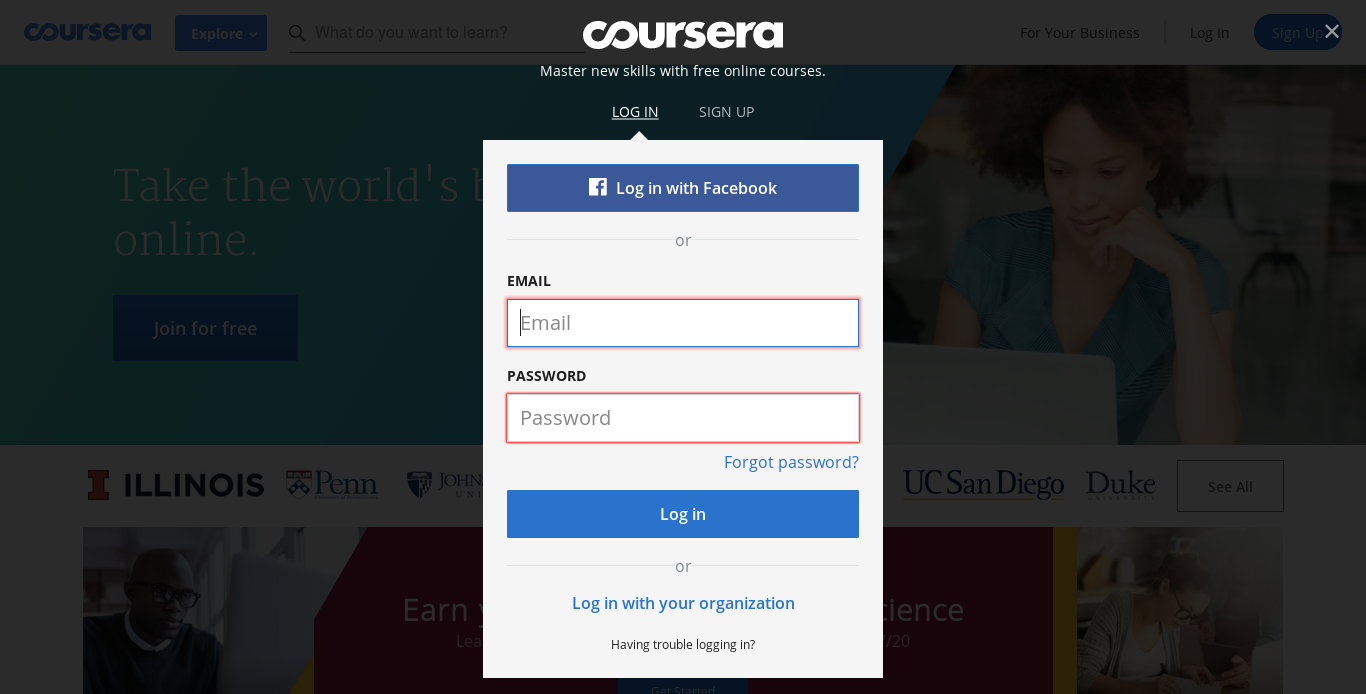

In [10]:
browser.visit('https://www.coursera.org/?authMode=login')
screenshot()

###  <b style="color:royalblue">Insert Login Credential</b>

In [11]:
#reset_credential() #uncomment to reset 
username, password = get_credential()

In [12]:
browser.visit('https://www.coursera.org/courses?authMode=login')

In [13]:
browser.fill('email', username)
browser.fill('password', password)

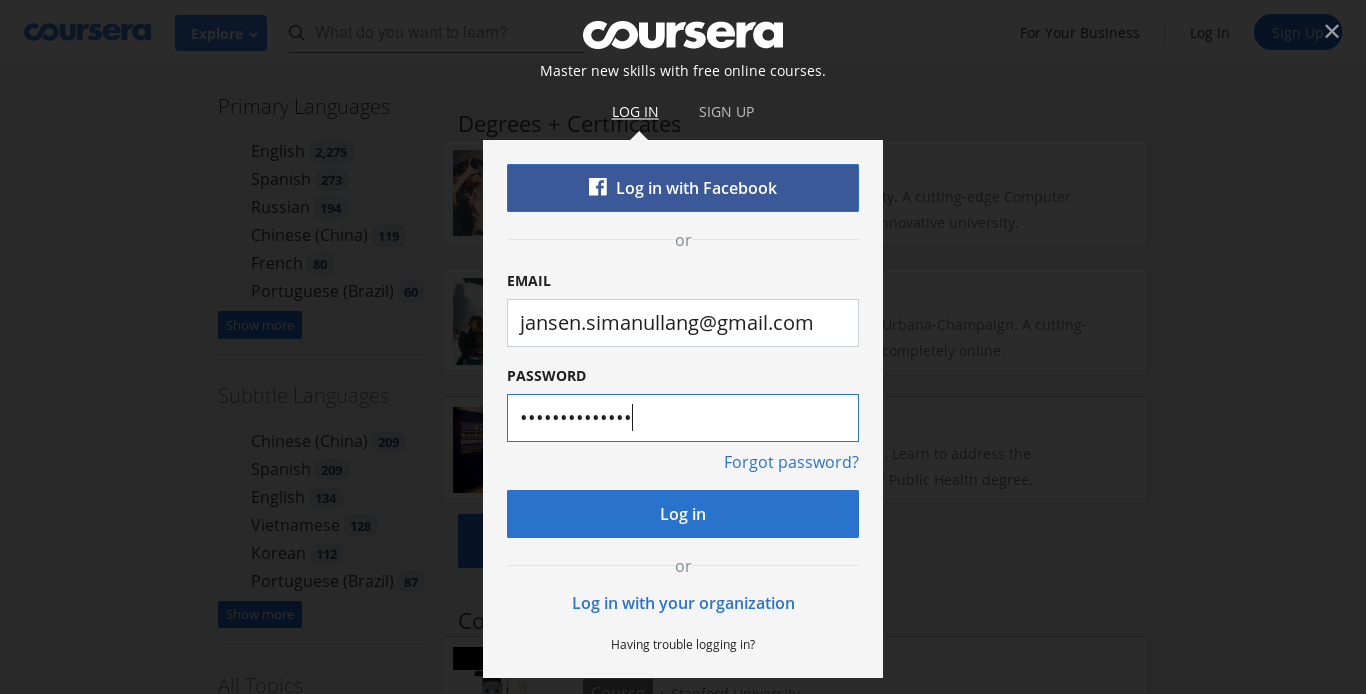

In [14]:
screenshot()

In [15]:
buttons = browser.find_by_tag('button')
for button in buttons:
    if (button.text == 'Log in'):
        button.click()
        break

###  <b style="color:royalblue">LAST ACTIVE COURSES</b>

In [16]:
browser.visit(homepage)
section = browser.find_by_tag('section')
titles = []

for s in section:
    title = s.find_by_tag('h4').text
    titles.append(title)

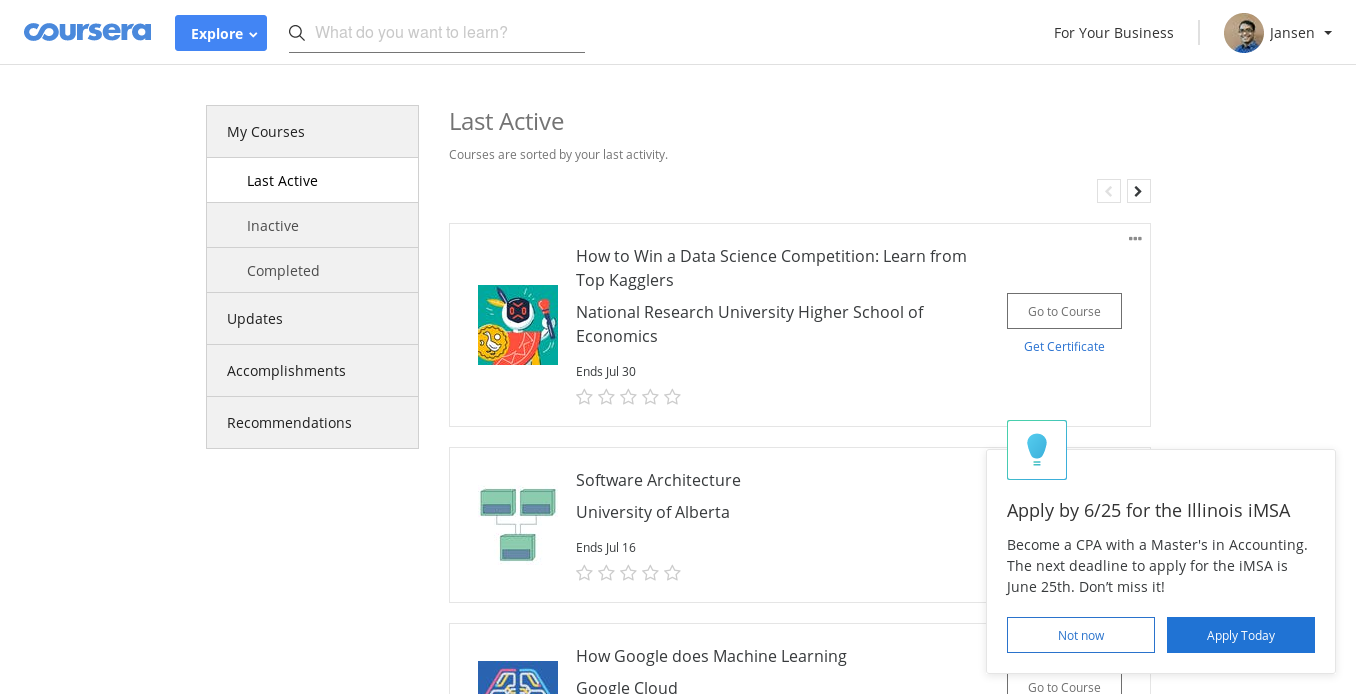

In [17]:
screenshot()

###  <b style="color:royalblue">PICK ONE OF THE COURSES</b>
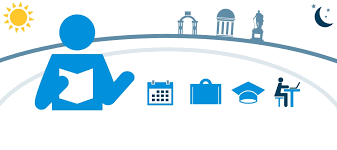

There are {{len(titles)}} courses visible in this section you can pick to download.

In [18]:
for i, title in enumerate(titles):
    print(i+1, title)
try:
    chosen_course = int(input('Choose a course number from [1] to ['+ str(len(titles))+']:\n'))
except:
    chosen_course = 1
course_title = titles[chosen_course-1]
print('>> You choose:\n'+course_title)

1 How to Win a Data Science Competition: Learn from Top Kagglers
2 Software Architecture
3 How Google does Machine Learning
4 Structuring Machine Learning Projects
5 Introduction to Deep Learning
6 Algorithmic Toolbox
7 Algorithms on Graphs
8 Stochastic processes
9 Advanced Algorithms and Complexity
10 Data Structures
11 Exploratory Data Analysis
12 Exploratory Data Analysis
13 Reproducible Research
Choose a course number from [1] to [13]:
1
>> You choose:
How to Win a Data Science Competition: Learn from Top Kagglers


In [19]:
section[chosen_course-1].click()
create_download_dir(course_title)

/home/bri/Development/my-github/www-coursera-downloader/How to Win a Data Science Competition Learn from Top Kagglers


 ### {{ titles[chosen_course-1] }}

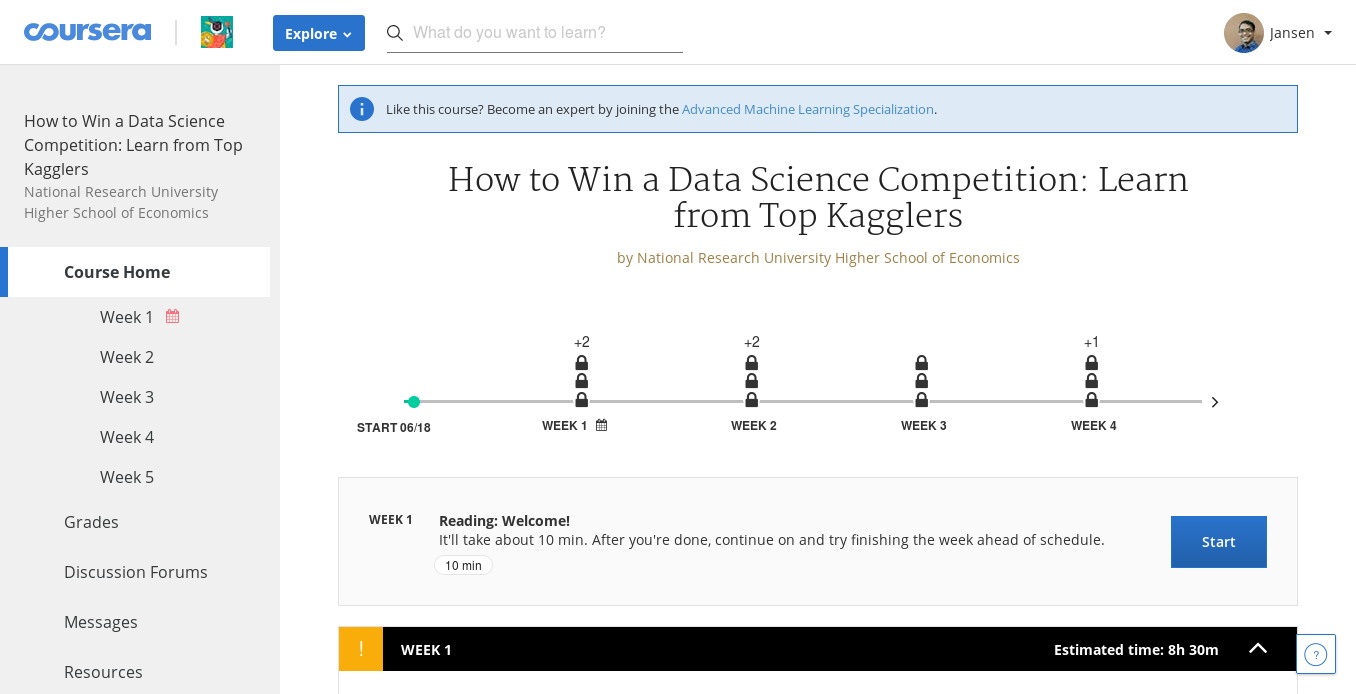

In [20]:
screenshot()

In [21]:
lecture_homepage = browser.driver.current_url

####  <b style="color:#3b5998">Enumerate Weeks</b>
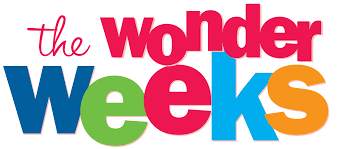

In [22]:
week = browser.find_by_css('div.rc-WeekCollectionNavigationItem > div')
anchors = BeautifulSoup(week.html, 'lxml').findAll('a', attrs={})
weeks = []
for a in anchors:
    weeks.append(a['href'])

weeks, len(weeks)

(['/learn/competitive-data-science/home/week/1',
  '/learn/competitive-data-science/home/week/2',
  '/learn/competitive-data-science/home/week/3',
  '/learn/competitive-data-science/home/week/4',
  '/learn/competitive-data-science/home/week/5'],
 5)

####  <b style="color:#3b5998">Enumerate Module Lessons</b>
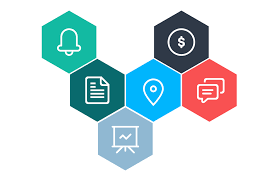

In [23]:
lessons_i = []
lessons_t = []
lessons_u = []
    
for w in range(len(weeks)):
    
    print('collecting lessons title and urls...\n')    
    browser.visit(homepage + weeks[w])
    time.sleep(loading_time)
    w = w+1
    
    print('\nVisiting week: ' + str(w))
    time.sleep(loading_time)
    module_lessons = browser.find_by_css('div.rc-ModuleLessons')
    print()
    print('Week '+str(w)+' titles:')
    seq = 0
    for i, module_lesson in enumerate(module_lessons):

        lessons_title = module_lesson.find_by_tag('h5')

        for j, l in enumerate(lessons_title):
            seq  += 1
            lesson_id = str(w*100+seq).zfill(3)
            title = l.text.replace('\n',' ')
            print(lesson_id, title)
            title = safe_text(title)
            lessons_t.append(title)
            lessons_i.append(lesson_id)
    
    print()
    print('Week '+str(w)+' links:')    
    seq = 0

    for i, module_lesson in enumerate(module_lessons):

        lessons_url = module_lesson.find_by_tag('ul')
    
        for j, e in enumerate(lessons_url):
            anchors = BeautifulSoup(e.html, 'lxml').findAll('a')
            for k, a in enumerate(anchors):
                seq += 1
                lesson_id = str(w*100+seq).zfill(3)
                lesson_url = a['href']
                print(lesson_id, lesson_url)
                lessons_u.append(lesson_url)
           
    print()

collecting lessons title and urls...


Visiting week: 1

Week 1 titles:
101 Lecture Introduction
102 Reading Welcome!
103 Lecture Meet your lecturers
104 Lecture Course overview
105 Reading Week 1 overview
106 Lecture Competition Mechanics
107 Lecture Kaggle Overview [screencast]
108 Lecture Real World Application vs Competitions
109 Practice Quiz: Practice Quiz
110 Lecture Recap of main ML algorithms
111 Reading Disclaimer
112 Practice Quiz: Recap
113 Quiz: Recap
114 Reading Explanation for quiz questions
115 Will performance of GBDT model drop dramatically if we remove the first tree?
116 Reading Additional Materials and Links
117 Lecture Software/Hardware Requirements
118 Practice Quiz: Software/Hardware
119 Pandas basics
120 Programming Assignment: Pandas basics
121 Quiz: Graded Soft/Hard Quiz
122 Reading Explanation for quiz questions
123 Reading Additional Material and Links
124 Lecture Overview
125 Lecture Numeric features
126 Lecture Categorical and ordinal features
127 Lecture


Visiting week: 3

Week 3 titles:
301 Reading Week 3 overview
302 Lecture Motivation
303 Lecture Regression metrics review I
304 Constants for MSE and MAE
305 Lecture Regression metrics review II
306 A note about weighted median
307 Lecture Classification metrics review
308 Lecture General approaches for metrics optimization
309 Lecture Regression metrics optimization
310 Lecture Classification metrics optimization I
311 Lecture Classification metrics optimization II
312 "Soft kappa" loss implementation
313 Practice Quiz: Metrics
314 Quiz: Metrics
315 Reading Comments on quiz
316 Reading Additional material and links
317 Lecture Concept of mean encoding
318 Lecture Regularization
319 Lecture Extensions and generalizations
320 Quiz: Mean encodings
321 Reading Comments on quiz
322 Mean encoding implementations notebook
323 Programming Assignment: Mean encoding implementation
324 Reading Final project advice #3

Week 3 links:
301 /learn/competitive-data-science/supplement/ybCfK/week-3-ove

### Download Lecture Videos and Readings
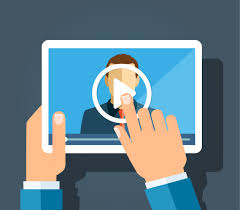

See the progress of downloading lecture videos, readings and quizzes.

In [24]:
os.chdir(initial_dirname)
os.chdir(safe_text(course_title))
lessons = zip(lessons_i, lessons_t, lessons_u)
for a,b,c in lessons:
    print(a,b)
    first_word = b.split(' ')[0]
    
    if 'Lecture' in first_word:
        mp4_downloader(a,b,c)
        vtt_downloader(a,b,c)
        print()
        
    elif 'Reading' in first_word:
        check_html_reading(a, b, c)
        print()
        
    elif ('Quiz' in first_word) or ('Practice Quiz' in b):
        quiz_downloader(a, b, c)
        print()
    
    else:
        print('no resource to download.')
        
    print()
print('Resources downloaded to:\n'+os.getcwd())
os.chdir(initial_dirname)

101 Lecture Introduction
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
vtt file being converted to srt: 101-Lecture Introduction.vtt

101-Lecture Introduction.srt
file created: 101-Lecture Introduction.srt



102 Reading Welcome!
html already downloaded.


103 Lecture Meet your lecturers
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
vtt file being converted to srt: 103-Lecture Meet your lecturers.vtt

103-Lecture Meet your lecturers.srt
file created: 103-Lecture Meet your lecturers.srt



104 Lecture Course overview
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
vtt file being converted to srt: 104-Lecture Course overview.vtt

104-Lecture Course overview.srt
file created: 104-Lecture Course overview.srt



105 Reading Week 1 overview
html already downloaded

requesting to download...
mp4 already downloaded.
subtitle already downloaded.
vtt file being converted to srt: 207-Lecture Visualizations.vtt

207-Lecture Visualizations.srt
file created: 207-Lecture Visualizations.srt



208 Lecture Dataset cleaning and other things to check
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
vtt file being converted to srt: 208-Lecture Dataset cleaning and other things to check.vtt

208-Lecture Dataset cleaning and other things to check.srt
file created: 208-Lecture Dataset cleaning and other things to check.srt



209 Quiz Exploratory data analysis
Resume
got quiz item


210 Reading Additional material and links
html already downloaded.


211 Notebook for the screencast
no resource to download.

212 Lecture Springleaf competition EDA I
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
vtt file being conve

Resume
got quiz item


314 Quiz Metrics
Resume
got quiz item


315 Reading Comments on quiz
html already downloaded.


316 Reading Additional material and links
html already downloaded.


317 Lecture Concept of mean encoding
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
vtt file being converted to srt: 317-Lecture Concept of mean encoding.vtt

317-Lecture Concept of mean encoding.srt
file created: 317-Lecture Concept of mean encoding.srt



318 Lecture Regularization
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
vtt file being converted to srt: 318-Lecture Regularization.vtt

318-Lecture Regularization.srt
file created: 318-Lecture Regularization.srt



319 Lecture Extensions and generalizations
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
vtt file being 

video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
vtt file being converted to srt: 503-Lecture Springleaf Marketing Response.vtt

503-Lecture Springleaf Marketing Response.srt
file created: 503-Lecture Springleaf Marketing Response.srt



504 Lecture Microsoft Malware Classification Challenge
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
vtt file being converted to srt: 504-Lecture Microsoft Malware Classification Challenge.vtt

504-Lecture Microsoft Malware Classification Challenge.srt
file created: 504-Lecture Microsoft Malware Classification Challenge.srt



505 Lecture Walmart Trip Type Classification
video playing will be paused in 5 seconds...
requesting to download...
mp4 already downloaded.
subtitle already downloaded.
vtt file being converted to srt: 505-Lecture Walmart Trip Type Classification.vtt

505-Lecture Walmart Trip Typ

### The Playlist
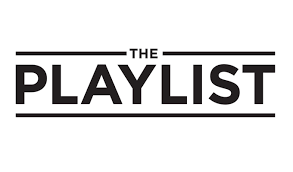

In [35]:
create_m3u_playlist()

playlist file created: "000-playlist.m3u"


##  <b style="color:#3b5998">D. In Case of an Error</b>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQXcI6o52Fkp4wQV6fET12lDBZl1ZfqQpwdGP9265fpkVu3hc6k8Q">

###  <b style="color:#3b5998">(1) Screenshot Checking</b>

In case of an error, you may want to check the screenshot. Here is an example:

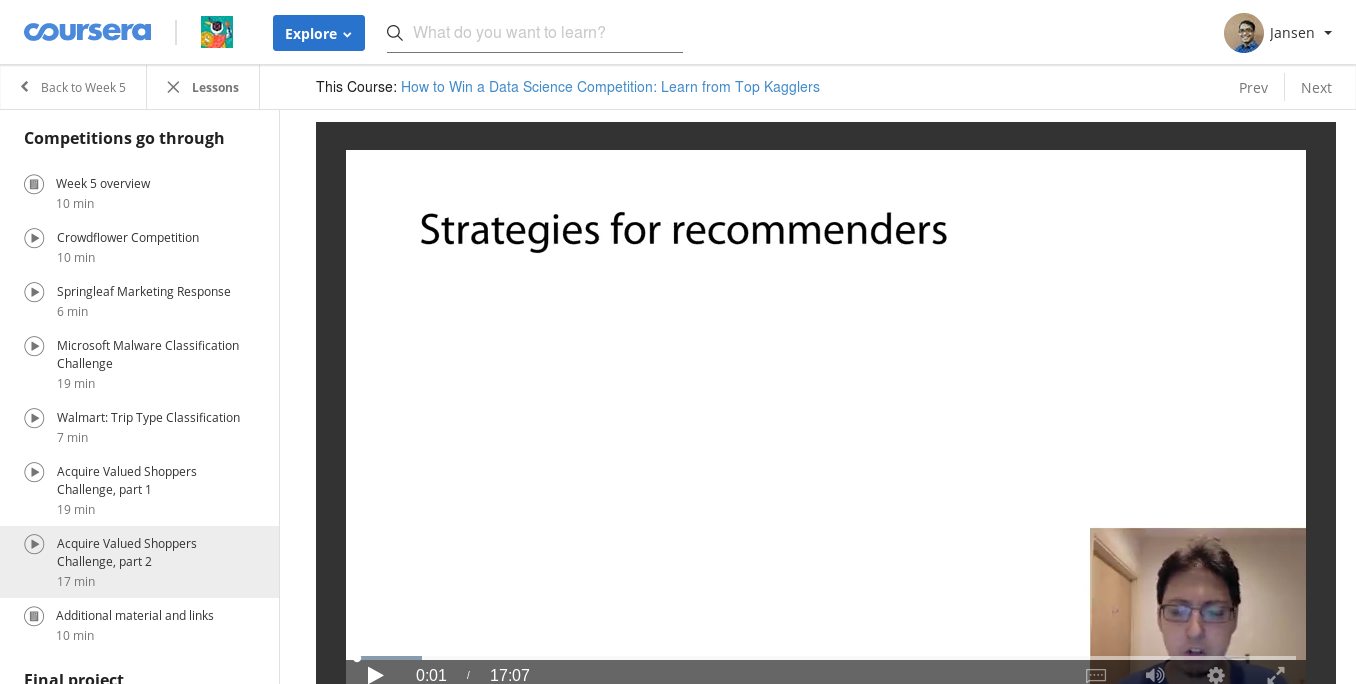

In [25]:
screenshot()

###  <b style="color:#3b5998">(2) Manually Calling Downloader Functions</b>

In [ ]:
resource_idx = {}
lessons = zip(lessons_i, lessons_t, lessons_u)
for a,b,c in lessons:
    resource_idx[a] = {'title':b, 'url':c}

# USER'S HELPER FUNCTIONS

def quiz_download_by_id(idx):
    a = idx,
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    quiz_downloader(a, b, c)
    
def mp4_download_by_id(idx):
    a = idx,
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    mp4_downloader(a, b, c) 
    
def html_download_by_id(idx):
    a = idx,
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    html_downloader(a, b, c)
    
def vtt_download_by_id(idx):
    a = idx,
    b = resource_idx[a]['title']
    c = resource_idx[a]['url']
    vtt_downloader(a, b, c)

### <b style="color:green">Examples of Manually Calling Functions</b>
<img src="https://images-na.ssl-images-amazon.com/images/I/41IRMu3-78L.jpg">

**`mp4_download_by_id`**

Example usage:

```
mp4_download_by_id('103')
```
is equivalent to:

**`mp4_downloader`** 

```
mp4_downloader('103',
               'Lecture Meet your lecturers',
               '/learn/competitive-data-science/lecture/k0D2h/meet-your-lecturers')
```
`103` means week `1` sequence number `03` which is a lecture

**`quiz_download_by_id`**
```
quiz_download_by_id('406')
```
is equivalent to:

**`quiz_downloader`** 

```
quiz_downloader('406',
               'Practice Quiz Practice quiz', 
               '/learn/competitive-data-science/quiz/k7xTP/practice-quiz')
```
`406` means week `4` sequence number `06` which is a quiz

In [ ]:
# Example usage
#mp4_download_by_id('103')

##  <b style="color:#3b5998">E. Close Browser After Download</b>
<img src="https://media.tenor.com/images/33c7bbf779e792d8a25ba1e5b80d8c9f/tenor.gif">

In [26]:
browser.quit()
os.chdir(initial_dirname)
os.getcwd()